Pipeline
    
    1) Removing HTML tagas and URLs, Punctiation*, Replacing emoticons*.
    2) Tokenization
    3) Removing Stop Words
    4) Splitting data: Training, Validation, Test
    5) TF-IDF Calculation

# Note about the code:
    Note that the dataset takes two paths, one towards the sentiment analysis
    and the other towards the analysis of some statistics related to the words/text

In [1]:
# Multilayer perceptron working environment.
# Getting ready the work environment. Importing libraries and modules: 
import time
import pandas as pd
import re
import nltk
import torch 
import torch.nn as nn
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_curve, roc_auc_score, confusion_matrix
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#===========         Extra tools for the statistic analysis              ======================
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
#----------------------------------------------------------------------

stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = CountVectorizer()

# 1) Importing data set

In [2]:
#Importing dataset
imdb_path = 'IMDB.csv'
imdb = pd.read_csv(imdb_path)

#Convert sentiment column to binary class
imdb['sentiment'] = imdb['sentiment'].map({'positive': 1, 'negative': 0})

#Checking data and columns
print(imdb.head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


# 2) Reducing size

In [3]:
#During the applycation of the model in earlier stages, the machine prompted "error" due to the large dataset
#Hence data is cut off to 5000 rows:

#Firstly, let's segregate the sentiment column:
positive_reviews = imdb[imdb['sentiment'] == 1]
negative_reviews = imdb[imdb['sentiment'] == 0]

#Secondly, sampling randomly 2500 reviews from each (+/-)
positive_sample = positive_reviews.sample(n=2500, random_state=42)
negative_sample = negative_reviews.sample(n=2500, random_state=42)

#Putting them together again
imdb_reduced = pd.concat([positive_sample, negative_sample])

#Suffling the new dataset
imdb_reduced = imdb_reduced.sample(frac=1, random_state=42).reset_index(drop=True)


#Sources: 
# https://stackoverflow.com/questions/71758460/effect-of-pandas-dataframe-sample-with-frac-set-to-1
# https://stackoverflow.com/questions/57300260/how-to-drop-added-column-after-using-df-samplefrac-1
# https://docs.python.org/3/library/fractions.html
# https://datascience.stanford.edu/news/splitting-data-randomly-can-ruin-your-model
# https://stats.stackexchange.com/questions/484000/how-to-appropriately-reduce-data-size-or-take-a-representative-sample-from-it

# 3) Preprocessing

## 3.1) Removing HTML tags and URLs, lower


    Note: I used a function to get rid of the punctuations however the dataset became massive and my machine was unable to manage. That's why I am avoiding it. 

In [4]:
#Function to remove HTML tags:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Sources: 
#https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python?newreg=aa9f4dc4aea341cc96661f3b6b26efd6
#https://beautiful-soup-4.readthedocs.io/en/latest/
#https://www.datacamp.com/tutorial/web-scraping-using-python
#https://www.geeksforgeeks.org/how-to-write-the-output-to-html-file-with-python-beautifulsoup/

In [5]:
#Function to remove URLs characteres:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

#Source: https://www.geeksforgeeks.org/remove-urls-from-string-in-python/

In [6]:
#Function to put together all the previous functions:
def preprocess_1(text):
    text = remove_html(text)
    text = remove_urls(text)
    text = text.lower()
    #text = remove_punctuation(text)///\\\\Initially used a function to remove punctuation, however the outcome was a new massive dataset making impossible to successfully run the whole code.
    return text

In [7]:
#Running the function to make the first preprocessing step.
imdb_reduced['review'] = imdb_reduced['review'].apply(preprocess_1)
imdb['review_preprocess_1'] = imdb['review'].apply(preprocess_1)

C:\Users\nonox\AppData\Local\Temp\ipykernel_16008\3164958809.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## 3.2) Tokenization and stopwords elimination.

In [8]:
#Function to tokenize and convert to lower case the text in review column
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

#Tokenization
imdb_reduced['Token'] = imdb_reduced['review'].apply(tokenize)
imdb['Token'] = imdb['review_preprocess_1'].apply(tokenize)

In [9]:
#Function to remove stop words from the tokenized review column
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

#Remove stopwords
imdb_reduced['Token'] = imdb_reduced['Token'].apply(remove_stopwords)
imdb['Token'] = imdb['Token'].apply(remove_stopwords)

# ** Statistic Analysis **
# .....................Starts

### A) Checking text

In [10]:
print(imdb.head())

                                              review  sentiment  \
0  One of the other reviewers has mentioned that ...          1   
1  A wonderful little production. <br /><br />The...          1   
2  I thought this was a wonderful way to spend ti...          1   
3  Basically there's a family where a little boy ...          0   
4  Petter Mattei's "Love in the Time of Money" is...          1   

                                 review_preprocess_1  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production. the filming tec...   
2  i thought this was a wonderful way to spend ti...   
3  basically there's a family where a little boy ...   
4  petter mattei's "love in the time of money" is...   

                                               Token  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, family, little, boy, jake

### B) Avg Words Positive Vs Negative:

In [11]:
#Calculating the total tokens for each review
imdb['token_count'] = imdb['Token'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#Dispersion and central tendency measurements
statistics = imdb.groupby('sentiment')['token_count'].agg(['min', 'max', 'mean', 'var', 'std'])

#Avg words per review:
avg_words = imdb['Token'].apply(len).mean()

#Print the statistics
print("Statistics by Sentiment: ")
print('\n')
print(statistics)
print('\n')
print('\n')
print('Average Words: ', f"{avg_words:.0f}")

#Resources:
#https://www.geeksforgeeks.org/pandas-groupby-one-column-and-get-mean-min-and-max-values/
#https://www.kaggle.com/code/akshaysehgal/ultimate-guide-to-pandas-groupby-aggregate

Statistics by Sentiment: 


           min   max       mean          var        std
sentiment                                              
0            3   824  117.81908  7385.840662  85.940914
1            6  1429  121.28256  8905.303412  94.367915




Average Words:  120


### C) Word Frequency

In [12]:
#Iterating through the list of lists(each row) to create a new list with all the tokens
def word_freq(list_of_list):
    single_list = [item for sublist in list_of_list for item in sublist]
    token_freq = Counter(single_list)
    return token_freq

#Counting the frequency for each word.
word_frequency = word_freq(imdb['Token'])
print(word_frequency)

#Sources: https://www.datacamp.com/tutorial/pandas-apply

Counter({'movie': 87934, 'film': 79669, 'one': 53585, 'like': 40160, 'good': 29737, 'time': 25099, 'even': 24855, 'would': 24599, 'story': 23108, 'really': 23089, 'see': 23021, 'well': 21259, 'much': 19314, 'bad': 18461, 'get': 18413, 'people': 18181, 'great': 18136, 'also': 17972, 'first': 17576, 'made': 16150, 'make': 15892, 'way': 15644, 'could': 15562, 'movies': 15301, 'characters': 14444, 'think': 14334, 'watch': 13938, 'character': 13900, 'films': 13750, 'two': 13541, 'many': 13443, 'seen': 13371, 'love': 13004, 'never': 12979, 'plot': 12975, 'life': 12911, 'acting': 12857, 'show': 12655, 'best': 12611, 'know': 12508, 'little': 12429, 'ever': 12013, 'man': 11820, 'better': 11426, 'end': 11115, 'scene': 10960, 'still': 10856, 'say': 10767, 'scenes': 10472, 'something': 10142, 'go': 9960, 'back': 9675, 'real': 9424, 'thing': 9168, 'watching': 9160, 'actors': 8948, 'director': 8804, 'years': 8757, 'funny': 8755, 'though': 8750, 'old': 8650, 'another': 8584, 'work': 8544, '10': 8473,

### D) Unique Words

In [13]:
unique_words = len(word_frequency.keys())
print('Unique_words: ',f'{unique_words}')

Unique_words:  103774


### E) Most common words

In [14]:
positive_words = Counter()
negative_words = Counter()

for index, row in imdb.iterrows():
    words = row['Token']
    sentiment = row['sentiment']
    if sentiment == 1:
        positive_words.update(words)
    else:
        negative_words.update(words)
    
#Resources: 
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
#https://www.kaggle.com/code/juicykn/imdb-movie-list-analysis-in-python-and-sql

In [15]:
top_positive_words = positive_words.most_common(10)
top_negative_words = negative_words.most_common(10)

print('Positive: ', top_positive_words)
print('\n')
print('Negative: ', top_negative_words)

Positive:  [('film', 42090), ('movie', 37844), ('one', 27312), ('like', 17709), ('good', 15020), ('great', 12961), ('story', 12931), ('time', 12745), ('well', 12724), ('see', 12271)]


Negative:  [('movie', 50090), ('film', 37579), ('one', 26273), ('like', 22451), ('even', 15243), ('good', 14717), ('bad', 14714), ('would', 14005), ('time', 12354), ('really', 12354)]


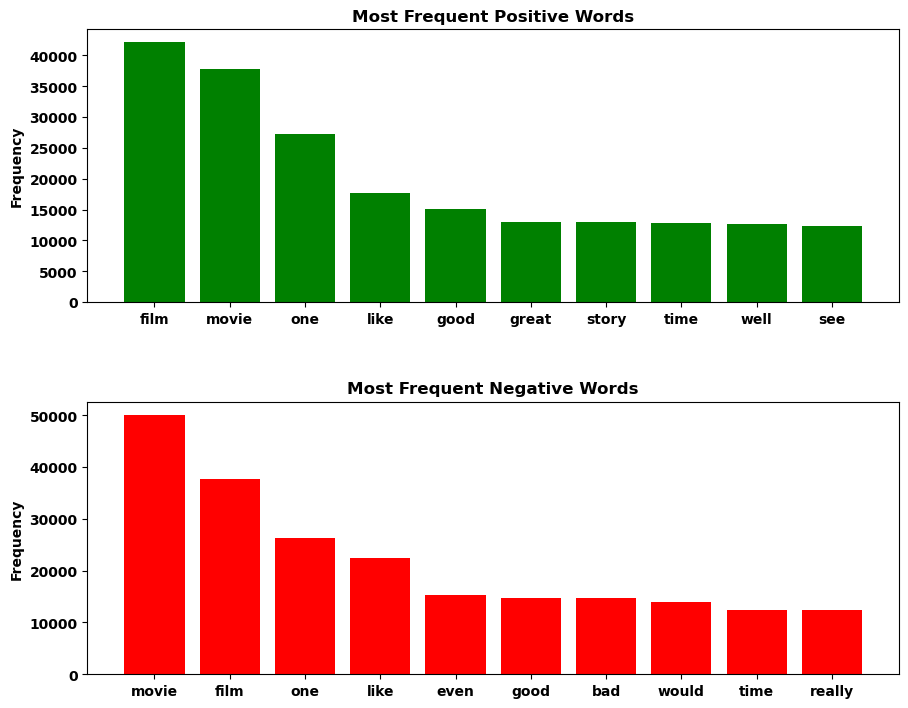

In [16]:
#Spliting the tupple we got earlier
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)

#Charts----------------------------------------------------
fig, axs = plt.subplots(2,1,figsize=(10,8))

#Positive words plot
axs[0].bar(positive_words, positive_counts, color='green')
axs[0].set_title('Most Frequent Positive Words')
axs[0].set_ylabel('Frequency')

#Negative words plot
axs[1].bar(negative_words, negative_counts, color='red')
axs[1].set_title('Most Frequent Negative Words')
axs[1].set_ylabel('Frequency')

#Space between charts
plt.tight_layout(pad=4.0)
plt.show()           
           
#Resources:
# https://realpython.com/python-zip-function/#using-zip-in-python
# https://matplotlib.org/stable/index.html

# ** Statistic Analysis **

# ....................................Finishes 

# Sentiment Analysis Continues

# 4) Splitting Data

In [17]:
#Splitting data into train 70%, validation 15%, test 15%

X_train_val, X_test, y_train_val, y_test = train_test_split(imdb_reduced['review'], imdb_reduced['sentiment'], test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# 5) TF-IDF Calculation

In [18]:
#Feature extraction: Transforming data into TF-IDF features.
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)
X_test = tfidf_vectorizer.transform(X_test)

In [19]:
print(X_train.shape)  # Should output (number_of_samples, 33154)
print(X_test.shape)   # Should also output (number_of_samples, 33154)
print(X_val.shape)

(3612, 33154)
(750, 33154)
(638, 33154)


# 6) Format conversion

In [20]:
#Turning sparse matrix into dense
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

#Turning into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

#Resources:
# https://pytorch.org/docs/stable/tensors.html

In [21]:
#We need to know the shape of the input vector to set the in put dimenssion.
input_dim = X_train.shape[1] 
print(input_dim)

33154


# 7) MLP model

In [22]:
# Time consumed (starts)
start_time = time.time()

#Building the Multilayer Perceptron model with back propagation.
class MLPmodel(nn.Module):
    def __init__(self):
        super(MLPmodel, self).__init__()
        self.fc1 = nn.Linear(33154,610)
        self.fc2 = nn.Linear(610,377)
        self.fc3 = nn.Linear(377,23)
        self.fc4 = nn.Linear(23,1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        output = self.sigmoid(self.fc4(hidden))
        return output
        

In [23]:
# Adam optimizer
model = MLPmodel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)  # Using Adam optimizer

In [24]:
epochs = 5000 # We limit the epochs to 5000 to limit the time spent
patience = 10 #Here we define how many epochs wait until we stop
best_val_loss = float('inf') #To save the best model/early stop
patience_counter = 0 #This one starts a counter to track number of epochs without improvement

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
  #Forward Pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
  #Backward and Optimize
    loss.backward()
    optimizer.step()

  #Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
       
  #Early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the best model state
        patience_counter=0
    else:
        patience_counter += 1
    
  #Print the early stopping
    if patience_counter > patience: 
        print(f'Stopping early at epoch {epoch+1}.')
        break
        
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
           
if best_model_state:
    model.load_state_dict(best_model_state)       
       
#Resources:
#https://pythonguides.com/pytorch-early-stopping/
#https://discuss.pytorch.org/t/can-i-deepcopy-a-model/52192
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
#https://github.com/Bjarten/early-stopping-pytorch
#https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/


Epoch 5/5000, Loss: 0.6939665079116821, Val Loss: 0.6941571831703186
Epoch 10/5000, Loss: 0.6939529776573181, Val Loss: 0.6941444873809814
Epoch 15/5000, Loss: 0.6939393877983093, Val Loss: 0.6941317319869995
Epoch 20/5000, Loss: 0.6939254403114319, Val Loss: 0.6941187977790833
Epoch 25/5000, Loss: 0.6939113140106201, Val Loss: 0.6941055059432983
Epoch 30/5000, Loss: 0.6938966512680054, Val Loss: 0.6940917372703552
Epoch 35/5000, Loss: 0.6938818693161011, Val Loss: 0.6940780878067017
Epoch 40/5000, Loss: 0.6938672065734863, Val Loss: 0.694064736366272
Epoch 45/5000, Loss: 0.693854033946991, Val Loss: 0.6940527558326721
Epoch 50/5000, Loss: 0.6938410401344299, Val Loss: 0.6940410137176514
Epoch 55/5000, Loss: 0.6938280463218689, Val Loss: 0.6940295100212097
Epoch 60/5000, Loss: 0.6938151717185974, Val Loss: 0.6940178275108337
Epoch 65/5000, Loss: 0.6938018202781677, Val Loss: 0.6940059065818787
Epoch 70/5000, Loss: 0.693788468837738, Val Loss: 0.693993866443634
Epoch 75/5000, Loss: 0.69

Epoch 590/5000, Loss: 0.685478925704956, Val Loss: 0.6878074407577515
Epoch 595/5000, Loss: 0.6851899027824402, Val Loss: 0.6876032948493958
Epoch 600/5000, Loss: 0.684891939163208, Val Loss: 0.6873931288719177
Epoch 605/5000, Loss: 0.6845850348472595, Val Loss: 0.6871773600578308
Epoch 610/5000, Loss: 0.6842691898345947, Val Loss: 0.6869557499885559
Epoch 615/5000, Loss: 0.6839444041252136, Val Loss: 0.686728298664093
Epoch 620/5000, Loss: 0.6836093664169312, Val Loss: 0.6864942312240601
Epoch 625/5000, Loss: 0.683264434337616, Val Loss: 0.6862534284591675
Epoch 630/5000, Loss: 0.6829090714454651, Val Loss: 0.6860058307647705
Epoch 635/5000, Loss: 0.6825433969497681, Val Loss: 0.6857519149780273
Epoch 640/5000, Loss: 0.6821677684783936, Val Loss: 0.6854922771453857
Epoch 645/5000, Loss: 0.6817816495895386, Val Loss: 0.6852260828018188
Epoch 650/5000, Loss: 0.681384265422821, Val Loss: 0.6849525570869446
Epoch 655/5000, Loss: 0.6809757351875305, Val Loss: 0.6846722364425659
Epoch 660/5

Epoch 1170/5000, Loss: 0.5317560434341431, Val Loss: 0.5908834934234619
Epoch 1175/5000, Loss: 0.5287042260169983, Val Loss: 0.5890734195709229
Epoch 1180/5000, Loss: 0.5256170630455017, Val Loss: 0.587239682674408
Epoch 1185/5000, Loss: 0.5224999785423279, Val Loss: 0.5853869915008545
Epoch 1190/5000, Loss: 0.5193573832511902, Val Loss: 0.5835187435150146
Epoch 1195/5000, Loss: 0.5161933898925781, Val Loss: 0.5816386342048645
Epoch 1200/5000, Loss: 0.5130094289779663, Val Loss: 0.5797520279884338
Epoch 1205/5000, Loss: 0.5098110437393188, Val Loss: 0.5778675079345703
Epoch 1210/5000, Loss: 0.5066003799438477, Val Loss: 0.5759832859039307
Epoch 1215/5000, Loss: 0.503379762172699, Val Loss: 0.5740995407104492
Epoch 1220/5000, Loss: 0.500148594379425, Val Loss: 0.5722125172615051
Epoch 1225/5000, Loss: 0.496906042098999, Val Loss: 0.5703213214874268
Epoch 1230/5000, Loss: 0.49365130066871643, Val Loss: 0.5684238076210022
Epoch 1235/5000, Loss: 0.49038517475128174, Val Loss: 0.56652384996

Epoch 1740/5000, Loss: 0.22023025155067444, Val Loss: 0.4152122139930725
Epoch 1745/5000, Loss: 0.21861547231674194, Val Loss: 0.4143317937850952
Epoch 1750/5000, Loss: 0.21701793372631073, Val Loss: 0.4134610593318939
Epoch 1755/5000, Loss: 0.21543781459331512, Val Loss: 0.412603497505188
Epoch 1760/5000, Loss: 0.21387597918510437, Val Loss: 0.41175177693367004
Epoch 1765/5000, Loss: 0.2123311311006546, Val Loss: 0.4109156131744385
Epoch 1770/5000, Loss: 0.2108050137758255, Val Loss: 0.410086065530777
Epoch 1775/5000, Loss: 0.20929498970508575, Val Loss: 0.4092668294906616
Epoch 1780/5000, Loss: 0.2078021764755249, Val Loss: 0.408457487821579
Epoch 1785/5000, Loss: 0.20632733404636383, Val Loss: 0.40765735507011414
Epoch 1790/5000, Loss: 0.2048679143190384, Val Loss: 0.4068678021430969
Epoch 1795/5000, Loss: 0.20342551171779633, Val Loss: 0.40608498454093933
Epoch 1800/5000, Loss: 0.20199912786483765, Val Loss: 0.4053140878677368
Epoch 1805/5000, Loss: 0.2005891650915146, Val Loss: 0.

Epoch 2305/5000, Loss: 0.11214081943035126, Val Loss: 0.35855919122695923
Epoch 2310/5000, Loss: 0.11160844564437866, Val Loss: 0.3583054840564728
Epoch 2315/5000, Loss: 0.11108078062534332, Val Loss: 0.35805395245552063
Epoch 2320/5000, Loss: 0.11055788397789001, Val Loss: 0.35780635476112366
Epoch 2325/5000, Loss: 0.11003923416137695, Val Loss: 0.3575606644153595
Epoch 2330/5000, Loss: 0.10952482372522354, Val Loss: 0.3573208153247833
Epoch 2335/5000, Loss: 0.109015554189682, Val Loss: 0.3570809066295624
Epoch 2340/5000, Loss: 0.10851031541824341, Val Loss: 0.35684603452682495
Epoch 2345/5000, Loss: 0.10800924897193909, Val Loss: 0.3566082715988159
Epoch 2350/5000, Loss: 0.10751261562108994, Val Loss: 0.35637935996055603
Epoch 2355/5000, Loss: 0.10701995342969894, Val Loss: 0.3561464548110962
Epoch 2360/5000, Loss: 0.10653181374073029, Val Loss: 0.3559202551841736
Epoch 2365/5000, Loss: 0.10604678094387054, Val Loss: 0.3556971549987793
Epoch 2370/5000, Loss: 0.10556679964065552, Val 

Epoch 2865/5000, Loss: 0.07227247208356857, Val Loss: 0.34155765175819397
Epoch 2870/5000, Loss: 0.07203881442546844, Val Loss: 0.3414742052555084
Epoch 2875/5000, Loss: 0.07180722057819366, Val Loss: 0.3413963317871094
Epoch 2880/5000, Loss: 0.07157681882381439, Val Loss: 0.34131181240081787
Epoch 2885/5000, Loss: 0.071347676217556, Val Loss: 0.3412263095378876
Epoch 2890/5000, Loss: 0.07112032920122147, Val Loss: 0.3411473333835602
Epoch 2895/5000, Loss: 0.07089395821094513, Val Loss: 0.34107092022895813
Epoch 2900/5000, Loss: 0.07066955417394638, Val Loss: 0.34099066257476807
Epoch 2905/5000, Loss: 0.07044641673564911, Val Loss: 0.3409138023853302
Epoch 2910/5000, Loss: 0.07022421061992645, Val Loss: 0.34083735942840576
Epoch 2915/5000, Loss: 0.07000391185283661, Val Loss: 0.3407617509365082
Epoch 2920/5000, Loss: 0.06978435069322586, Val Loss: 0.34068387746810913
Epoch 2925/5000, Loss: 0.06956668943166733, Val Loss: 0.3406123220920563
Epoch 2930/5000, Loss: 0.0693502426147461, Val 

Epoch 3425/5000, Loss: 0.052978888154029846, Val Loss: 0.3356807231903076
Epoch 3430/5000, Loss: 0.05285358428955078, Val Loss: 0.33565232157707214
Epoch 3435/5000, Loss: 0.05272865667939186, Val Loss: 0.3356280028820038
Epoch 3440/5000, Loss: 0.05260464921593666, Val Loss: 0.33559489250183105
Epoch 3445/5000, Loss: 0.052481215447187424, Val Loss: 0.33556830883026123
Epoch 3450/5000, Loss: 0.05235828831791878, Val Loss: 0.3355422616004944
Epoch 3455/5000, Loss: 0.05223630741238594, Val Loss: 0.33551403880119324
Epoch 3460/5000, Loss: 0.05211431160569191, Val Loss: 0.3354857265949249
Epoch 3465/5000, Loss: 0.05199355632066727, Val Loss: 0.33546018600463867
Epoch 3470/5000, Loss: 0.0518730953335762, Val Loss: 0.33542877435684204
Epoch 3475/5000, Loss: 0.051753416657447815, Val Loss: 0.33540287613868713
Epoch 3480/5000, Loss: 0.05163412168622017, Val Loss: 0.33537498116493225
Epoch 3485/5000, Loss: 0.05151544511318207, Val Loss: 0.33534863591194153
Epoch 3490/5000, Loss: 0.051397297531366

Epoch 3985/5000, Loss: 0.042079824954271317, Val Loss: 0.3339267373085022
Epoch 3990/5000, Loss: 0.042005106806755066, Val Loss: 0.3339255750179291
Epoch 3995/5000, Loss: 0.04193059355020523, Val Loss: 0.3339165449142456
Epoch 4000/5000, Loss: 0.041856732219457626, Val Loss: 0.33391162753105164
Epoch 4005/5000, Loss: 0.04178284481167793, Val Loss: 0.33390823006629944
Epoch 4010/5000, Loss: 0.0417095348238945, Val Loss: 0.33390119671821594
Epoch 4015/5000, Loss: 0.04163608327507973, Val Loss: 0.3338981866836548
Epoch 4020/5000, Loss: 0.04156329482793808, Val Loss: 0.3338911533355713
Epoch 4025/5000, Loss: 0.04149070009589195, Val Loss: 0.33388984203338623
Epoch 4030/5000, Loss: 0.04141853004693985, Val Loss: 0.3338874280452728
Epoch 4035/5000, Loss: 0.041346367448568344, Val Loss: 0.33388057351112366
Epoch 4040/5000, Loss: 0.04127482697367668, Val Loss: 0.33387652039527893
Epoch 4045/5000, Loss: 0.0412033274769783, Val Loss: 0.33387264609336853
Epoch 4050/5000, Loss: 0.04113216698169708

In [25]:
#Accuracy on validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_predicted_bin = (val_outputs.squeeze() > 0.5).int()
    
    #validation accuracy
    val_accuracy = accuracy_score(y_val.numpy(), val_predicted_bin.numpy())
    print(f'Validation set accuracy: {val_accuracy:.2f}')
    
# Resources:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html
# https://www.youtube.com/watch?v=E35CVhVKISA&t=135s

Validation set accuracy: 0.8479623824451411


In [26]:
#Accuracy on test set
model.eval()

with torch.no_grad():
    test_outputs = model(X_test)
    predicted_bin = (test_outputs.squeeze() > 0.5).int()
    
#accuracy
test_accuracy = accuracy_score(y_test.numpy(), predicted_bin.numpy())
print(f'Accuracy on test set: {test_accuracy:.2f}')

#classification report
print(classification_report(y_test.numpy(), predicted_bin.numpy()))

Accuracy on test set: 0.84
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85       395
         1.0       0.82      0.86      0.84       355

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.85      0.84      0.84       750



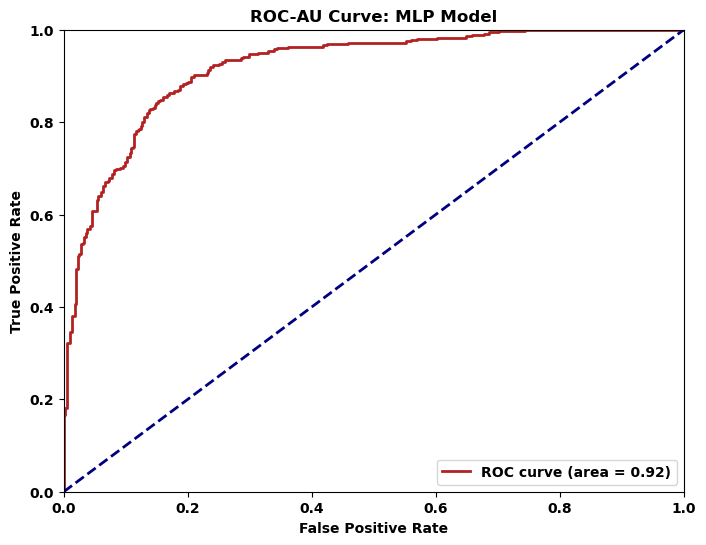

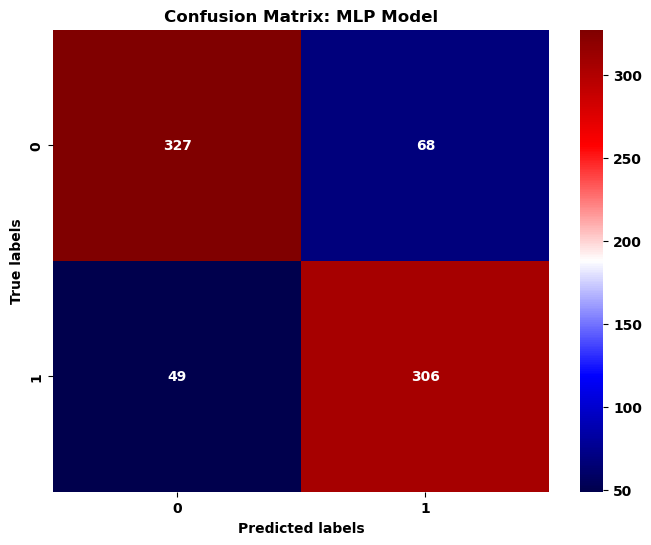

In [27]:
#Turning tensors into NumPy arrays so we can use Scikit-learn functions
test_outputs_np = test_outputs.squeeze().numpy()
y_test_np = y_test.numpy()

#Calculation of the ROC-AU
fpr, tpr, thresholds = roc_curve(y_test_np, test_outputs_np)
roc_auc = roc_auc_score(y_test_np, test_outputs_np)

#Plotting the ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='firebrick', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AU Curve: MLP Model')
plt.legend(loc="lower right")

plt.show()

#Calculation of the confusion matrix
cm = confusion_matrix(y_test.numpy(), predicted_bin.numpy())

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap='seismic')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: MLP Model')

plt.show()


In [28]:
#Total Time Consumed 
end_time = time.time()
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time} seconds")

Total Execution Time: 11198.268087863922 seconds
